# Detección de fraude

Detección de fraude en tarjetas de crédito usando un dataset anonimizado de Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).  
Se define fraude en tarjetas como  los casos de utilización para transacciones financieras sin la información del propietario de la tarjeta.  
  
El objetivo es clasificar cuando una transacción es real o fraudulenta y manejar un **set de datos desbalanceados**. Es una **clasificación binaria**.


----------------------

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import RocCurveDisplay

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
WarningMessage = False
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [40]:
data = pd.read_csv('data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


Contiene solamente variables de entrada numéricas que son el resultado de una transformación PCA (por temas de confidencialidad).    
Los campos V1, V2, ... V28 son los componentes principales obtenidos a través de PCA.

In [41]:
data.shape

(284807, 31)

# Análisis exploratorio

Como indica la descripción del dataset, este contiene transacciones realizadas con tarjetas de crédito durante septiembre de 2013 por titulares europeos. 
Presenta transacciones que ocurrieron en dos días, donde tenemos 492 fraudes de un total de 284.807 transacciones. La clase positiva (fraudes) representa el **0,172%** de todas las transacciones.

In [42]:
data.value_counts('Class')

Class
0    284315
1       492
dtype: int64

In [43]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


## Visualización de los datos

Visualización para comprender de mejor manera el output que se obtiene de describir los datos con `describe()`

In [44]:
fraud = data[data['Class'] == 1].describe().T[['mean']].rename({'mean':'mean Fraude'}, axis=1)
nofraud = data[data['Class'] == 0].describe().T[['mean']].rename({'mean':'mean No Fraude'}, axis=1)

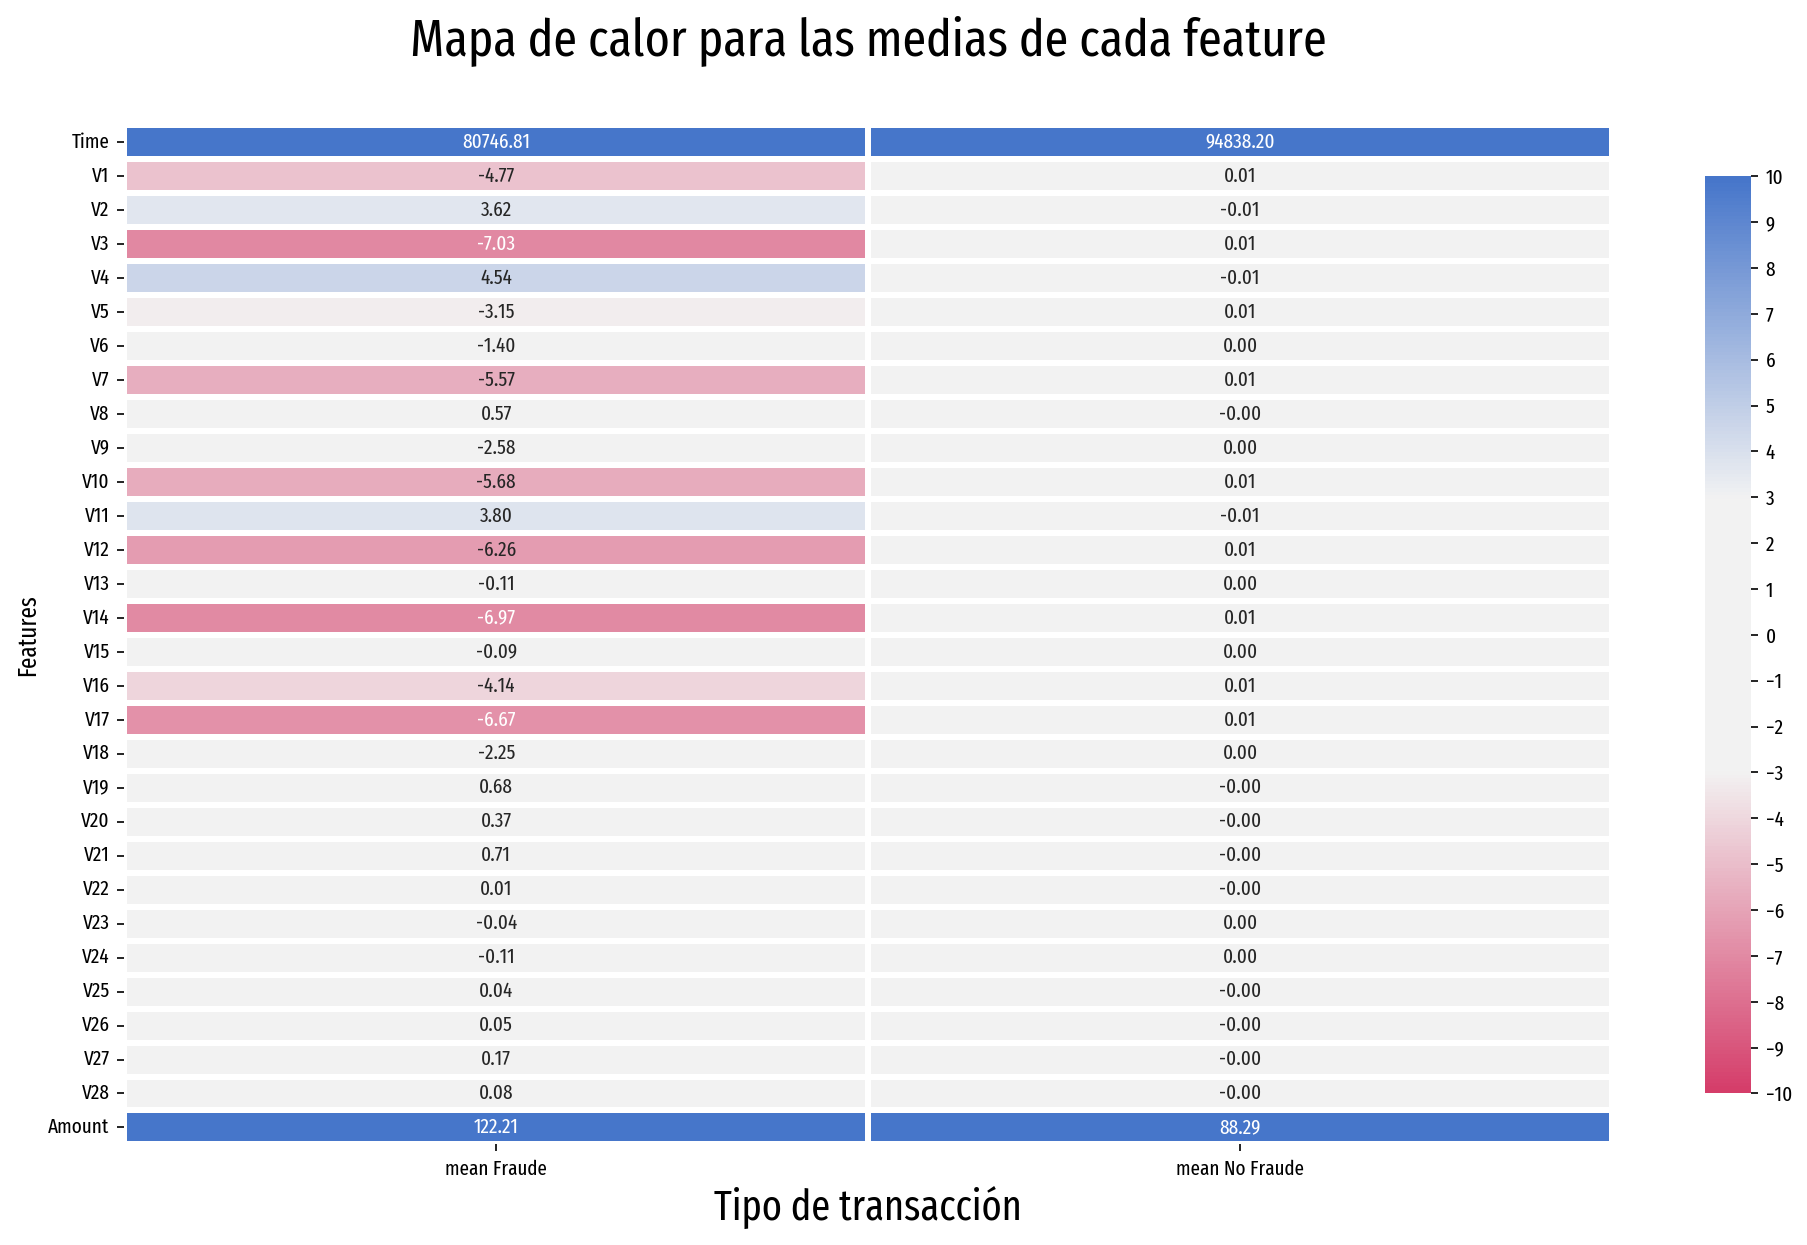

In [45]:
plt.figure(figsize= (16,9)) 
 # barra lateral
cbar_kws = {"orientation":"vertical", 
            "shrink":0.9,
            "ticks":np.arange(-10,31), 
           } 

# paleta de colores
cmap = sns.diverging_palette(0, 255, sep=77, as_cmap=True)
 
 # heatmap
sns.heatmap(pd.concat([fraud, nofraud], axis=1).drop('Class'), 
vmin = -10, vmax = 10, 
cmap=cmap, 
annot = True, 
linewidth = 2, 
cbar_kws=cbar_kws, fmt = '.2f')
 
plt.title("Mapa de calor para las medias de cada feature\n", fontsize = 25)
plt.xlabel("Tipo de transacción", fontsize = 20)
plt.ylabel("Features", fontsize = 12)
plt.show()

## Análisis de correlación de features

In [46]:
fraud = data[data['Class'] == 1].reset_index(drop=True)
no_fraud = data[data['Class'] == 0].reset_index(drop=True)

# get correlations
fraud_corr = fraud.corr(method='spearman')
no_fraud_corr = no_fraud.corr(method='spearman')
# irrelevant fields
fields = ['Time', 'Class']
# drop rows
fraud_corr.drop(fields, inplace=True)
no_fraud_corr.drop(fields, inplace=True)
# drop cols
fraud_corr.drop(fields, axis=1, inplace=True)
no_fraud_corr.drop(fields, axis=1, inplace=True)

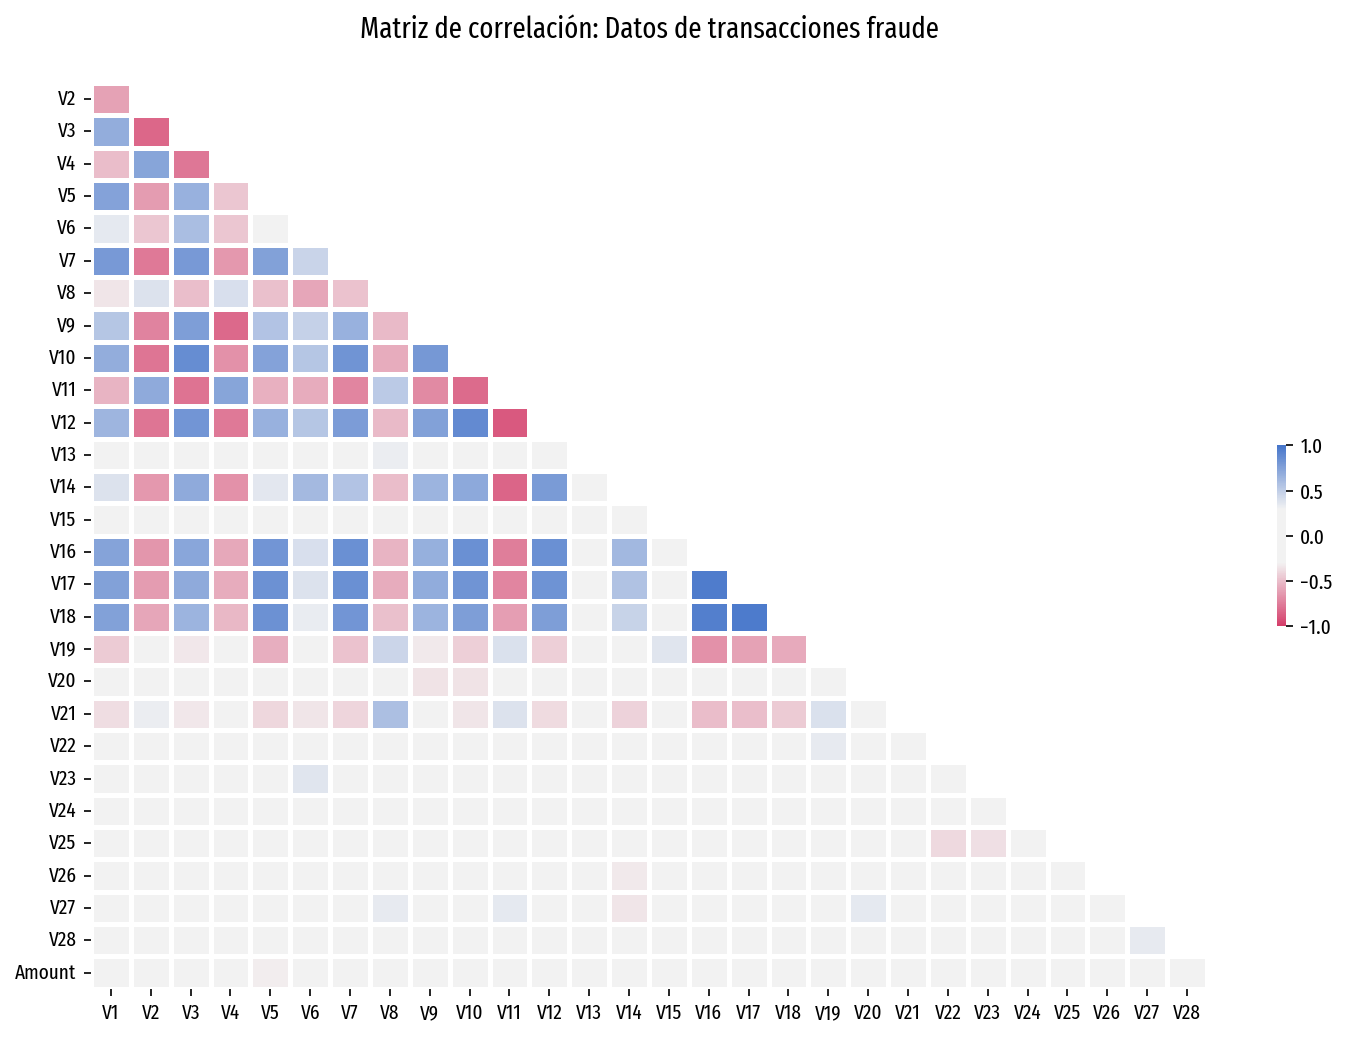

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
# mask
mask = np.triu(np.ones_like(fraud_corr, dtype=bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = fraud_corr.iloc[1:,:-1].copy()
# color map
#cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
cmap = sns.diverging_palette(0, 255, sep=77, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", 
           linewidths=1.5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .2}, square=False)

# title
plt.title('Matriz de correlación: Datos de transacciones fraude\n', fontsize=14)
plt.show()

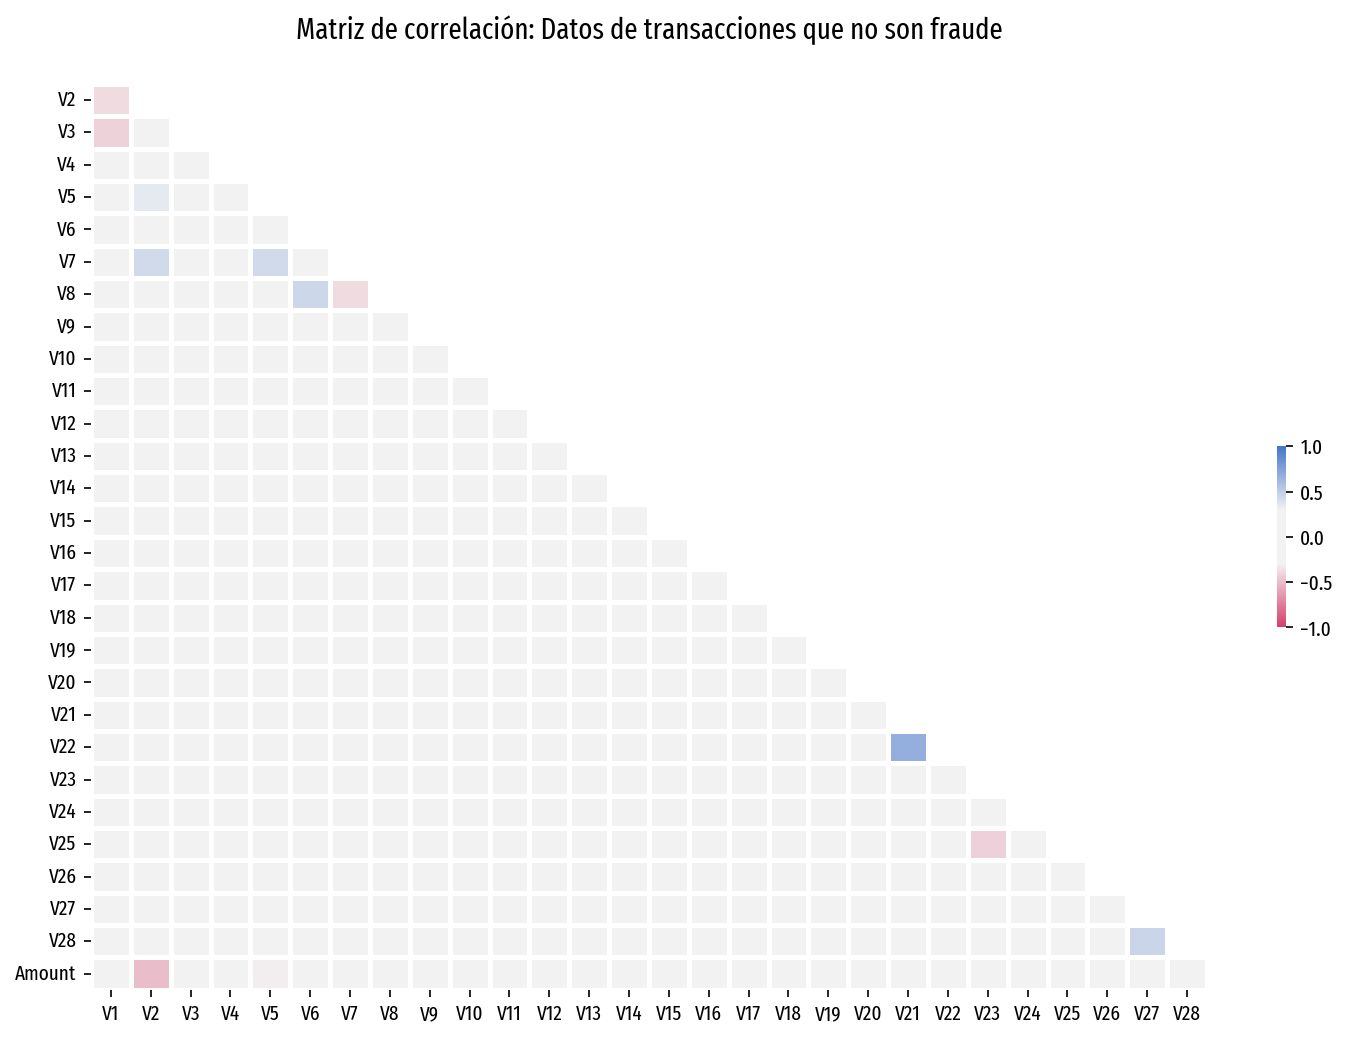

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))
# mask
mask = np.triu(np.ones_like(no_fraud_corr, dtype=bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = no_fraud_corr.iloc[1:,:-1].copy()
# color map
#cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
cmap = sns.diverging_palette(0, 255, sep=77, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", 
           linewidths=1.5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .2}, square=False)

# title
plt.title('Matriz de correlación: Datos de transacciones que no son fraude\n', fontsize=14)
plt.show()

# Clases

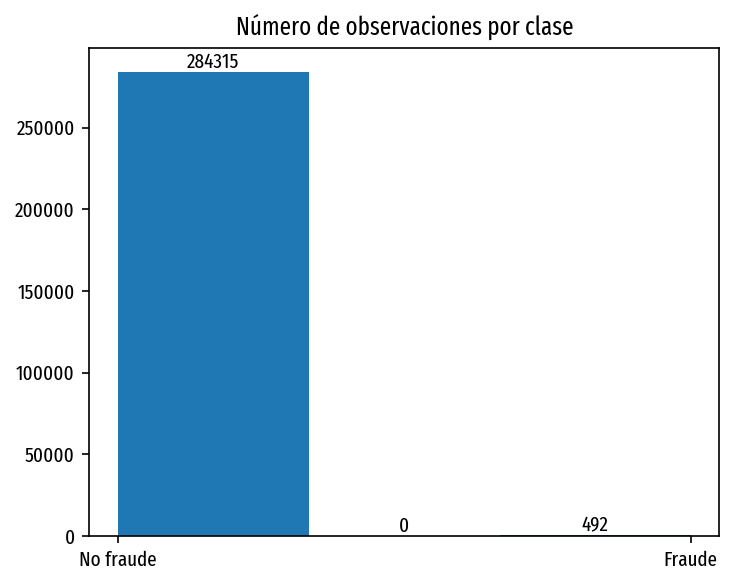

In [48]:
plt.figure(figsize=(5, 4))
counts, edges, bars = plt.hist(data.Class.astype(str).values, bins=3)
plt.bar_label(bars)
plt.xticks([0,1],labels=['No fraude', 'Fraude'])
plt.title("Número de observaciones por clase")
plt.tight_layout()
plt.show()


* Los datos están **MUY** desbalanceados, mayoría de transacciones corresponden a No Fraude. Hay que tener esto en consideración al momento de seleccionar el modelo de clasificación (producto del sesgo) y lo mismo aplica para seleccionar la métrica para evaluar posteriormente el modelo.  
* Utilizar técnicas de balanceo de datos parece ser lo adecuado. Se probará con oversampling y SMOTE. Se quiere consutruir un modelo robusto.

#  Selección de features con ANOVA

Las variables del set de datos fueron obtenidas a través de PCA, por lo que para seleccionar las variables se utilizará ANOVA ( Analysis of Variance). ANOVA es un método estadístico que puede utilizarse para la selección de features. Se utiliza para determinar la importancia de diferentes features en un conjunto de datos, comparando las medias de la variable objetivo para sus diferentes niveles. Define sus hipótesis de la siguiente manera:


$Ho: La\ media\ de\ los\ grupos\ es\ igual$  
$H1: Al\ menos\ una\ media\ de\ los\ grupos\ es\ diferente$

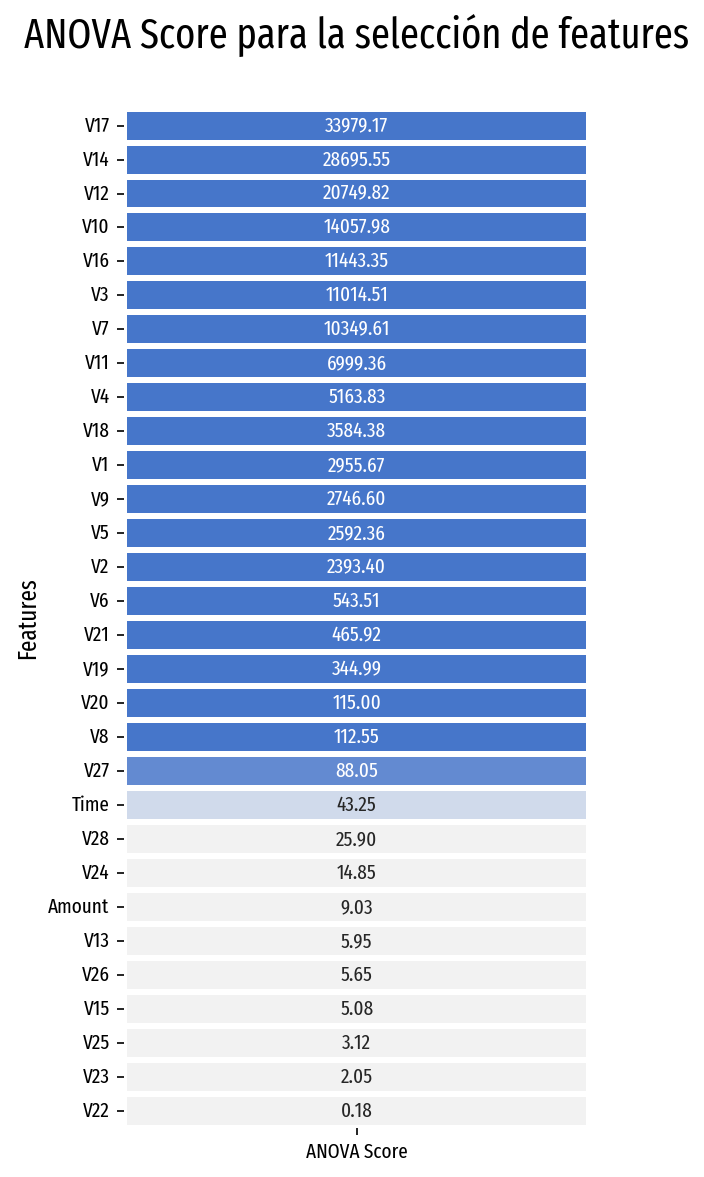

In [49]:
features = data.loc[:,:'Amount']
target = data.loc[:,'Class']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 
featureScores = featureScores.sort_values(ascending = False,by = 'ANOVA Score')

plt.figure(figsize= (4,9))  

# paleta de colores
cmap = sns.diverging_palette(0, 255, sep=77, as_cmap=True)
 
 # heatmap
sns.heatmap(featureScores, 
vmin = -100, vmax = 100, 
cmap=cmap, 
cbar=False,
annot = True, 
linewidth = 2, 
fmt = '.2f')
 
plt.title("ANOVA Score para la selección de features\n", fontsize = 20)
plt.ylabel("Features", fontsize = 12)
plt.show()


A mayor valor del  ANOVA Score, mayor será la importancia de esa característica respecto a variable objetivo.  
Por lo que seleccionaremos variables desde un ANOVA Score superior a 40. (Corte en variable "Time")


In [50]:
feature_list = featureScores[featureScores['ANOVA Score'] > 26].index.to_list()

In [51]:
# Añado item de la variable Clase
feature_list.extend(['Class'])

In [52]:
df1 = data[feature_list]
df1.head()

,V17,V14,V12,V10,V16,V3,V7,V11,V4,V18,...,V5,V2,V6,V21,V19,V20,V8,V27,Time,Class
0,0.21,-0.31,-0.62,0.09,-0.47,2.54,0.24,-0.55,1.38,0.03,...,-0.34,-0.07,0.46,-0.02,0.40,0.25,0.10,0.13,0.00,0
1,-0.11,-0.14,1.07,-0.17,0.46,0.17,-0.08,1.61,0.45,-0.18,...,0.06,0.27,-0.08,-0.23,-0.15,-0.07,0.09,-0.01,0.00,0
2,1.11,-0.17,0.07,0.21,-2.89,1.77,0.79,0.62,0.38,-0.12,...,-0.50,-1.34,1.80,0.25,-2.26,0.52,0.25,-0.06,1.00,0
3,-0.68,-0.29,0.18,-0.05,-1.06,1.79,0.24,-0.23,-0.86,1.97,...,-0.01,-0.19,1.25,-0.11,-1.23,-0.21,0.38,0.06,1.00,0
4,-0.24,-1.12,0.54,0.75,-0.45,1.55,0.59,-0.82,0.40,-0.04,...,-0.41,0.88,0.10,-0.01,0.80,0.41,-0.27,0.22,2.00,0


# Balanceo de datos - SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) es una técnica utilizada para balancear set de datos mediante un sobremuestreo de la clase/target minoritaria. El algoritmo funciona seleccionando una instancia aleatoria de clase minoritaria  y calculando sus k-vecinos más cercanos. A continuación, genera una nueva muestra a partir del rango del espacio de características de la instancia seleccionada y sus vecinos. Esta nueva muestra se añade al  set de datos y este proceso se repite hasta alcanzar el  balanceo deseado.  

Para  el undersampling se usará una `sampling_strategy` de 0.1 equivalente a 4920 observaciones de la clase mayoritaria.  $$4920 * 0.1=\ N°\ obs\ clase\ minoritaria\ (492)$$

 **Clase no fruade** : 4920 samples  
 **Clase Fraude** : 492 samples  

 Para la estrategia de oversampling se usará SMOTE con `sampling_strategy` de 0.5  quedando de la siguiente manera:  


 O lo que es equivalente a:   

  $$ 0.5 =  \frac{Clase\ minoritaria}{4920}$$  

  Por lo que finalmente la frecuencia de las clases queda:  
  
   **Clase No Fraude** : 4920 obs.  
   **Clase Fraude** : 2460 obs.  



In [53]:
def balancear_dataset_SMOTE(dataset, target):
    """ Función que toma un set de datos desbalanceado y separa 
         en features y etiqueta para para su balanceo usando undersample y SMOTE 

    Args:
        dataset (_type_): pd.Dataframe
        target (_type_): variable objetivo

    Returns:
        _type_: pd.DataFrame
    """    
    #separa los datos en características y etiquetas
    X = dataset.drop(target, axis=1) 
    y = dataset[target]

    #balancear el dataset usando SMOTE para oversampling y RUS para undersampling
    under = RandomUnderSampler(sampling_strategy = 0.1)
    over = SMOTE(sampling_strategy = 0.5, random_state=42)


    steps = [('under', under),('over', over)]
    pipeline = Pipeline(steps=steps)

    X_res, y_res = pipeline.fit_resample(X, y)

    return X_res, y_res

In [54]:
X, y = balancear_dataset_SMOTE(df1, "Class")

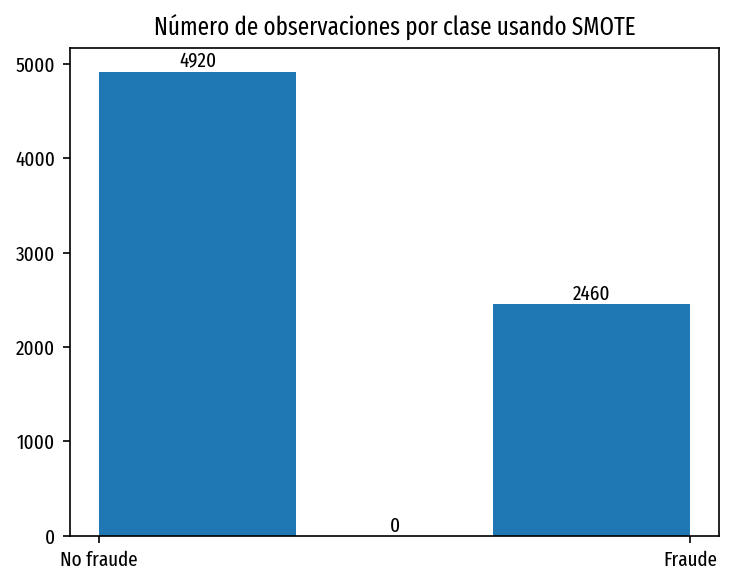

In [55]:
plt.figure(figsize=(5, 4))
counts, edges, bars = plt.hist(y.astype(str).values, bins=3)
plt.bar_label(bars)
plt.xticks([0,1],labels=['No fraude', 'Fraude'])
plt.title("Número de observaciones por clase usando SMOTE")
plt.tight_layout()
plt.show()

# Modelos

Primero, separamos los datos en test y entrenamiento. Usaremos un `train_test_split` estratificado en una proporción de 80% y 20% respectivamente

In [56]:
from sklearn import preprocessing, metrics, model_selection

In [57]:
TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TEST_SIZE, 
                                                                                              random_state=2, stratify=y)

In [58]:
def model(classifier,x_train,y_train,x_test,y_test):
    """ Función que generá un modelo y retorna Cross Validation Score, ROC_AUC Score y  un gráfico de ROC_AUC 
    Args:
        classifier (_type_): modelo clasificador
        x_train (_type_): features de entrenamiento
        y_train (_type_): targets correspondientes al set de entrenamiento
        x_test (_type_): features de test
        y_test (_type_): targets correspondientes al set de test
    """    
    # Fit del clasificador
    classifier.fit(x_train,y_train)
    # Predict
    prediction = classifier.predict(x_test)
    # Cross Validation usando  repeated KFold estratificado
    cv = model_selection.RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state =2)
    #Print de CVScore
    print("Cross Validation Score : ",'{0:.2%}'.format(model_selection.cross_val_score(classifier,
    x_train,
    y_train,
    cv = cv,
    scoring = 'roc_auc').mean()))
    
    # Print de Score ROC AUC
    print("ROC_AUC Score : ",'{0:.2%}'.format(metrics.roc_auc_score(y_test,prediction)))
    plt.figure(figsize=(5, 4))
   
    RocCurveDisplay.from_estimator(classifier, x_test,y_test)
    plt.title('Curva ROC_AUC')
    plt.show()

In [66]:
def model_evaluation(classifier,x_test,y_test):
    """Función para evaluar un modelo de clasificación. 
        El código crea una matriz de confusión y un informe de clasificación para el clasificación especificado en los parámetros. 

    Args:
        classifier (_type_): clasificador
        x_test (_type_): features de test
        y_test (_type_): y de test
    """

    # Confusion Matrix
    cm = metrics.confusion_matrix(y_test,classifier.predict(x_test), normalize="true")
    names = ['Verdadero Neg','Falso Pos','Falso Neg','Verdadero Pos']
    counts = ['{0:.2%}'.format(value) for value in cm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names,counts)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    plt.title('Matriz de confusión')
    plt.show()
    
    # Classification Report
    print(metrics.classification_report(y_test,classifier.predict(x_test)))



## Regresión logística

Como modelo de línea base se usará una regresión logística.  Este modelo es un algoritmo de **ML supervizado** que se utiliza para **tareas de clasificación**. Sirve para predecir la probabilidad de ocurrencia de un evento dado un conjunto de variables independientes. 

Matemáticamente, está definido como:  

$$P(Y=1|X) = \frac{1}{1+e^{-(\\beta\_0 + \\beta\_1X\_1 + \\beta\_2X\_2 + ... + \\beta\_nX\_n)}}$$

Donde  $P(Y=1|X)$  es la probabilidad de ocurrencia del evento , $\\beta\_0$ es el intercepto, y $\\beta\_1, \\beta\_2, ..., \\beta\_n$ son los coeficientes de las variables independientes  $X\_1, X\_2, ..., X\_n$

Se usará `RepeatedStratifiedKFold` de `scikit-learn`, la cual es una técnica de validación cruzada que se puede utilizar para evaluar el rendimiento de un modelo. Es una variación de la técnica tradicional de validación cruzada K-Fold, y a diferencia, esta se repite varias veces (`n_splits`) y en donde cada  Fold está estratificado,  esto garantiza que los datos se distribuyan uniformemente en cada fold para así reducir el sesgo y mejorar la precisión del modelo.

El término de penalización `L2` se calcula como la suma del cuadrado de los coeficientes de regresión. Esto significa que los modelos con coeficientes más grandes tendrán un mayor costo y, por lo tanto, serán menos probables. El objetivo final es encontrar los coeficientes óptimos que minimicen el error de entrenamiento y eviten el sobreajuste.

In [60]:
model_LR = LogisticRegression(random_state = 0,
C=10,
penalty= 'l2',
max_iter=1000) 

Cross Validation Score :  98.84%
ROC_AUC Score :  96.49%


<Figure size 750x600 with 0 Axes>

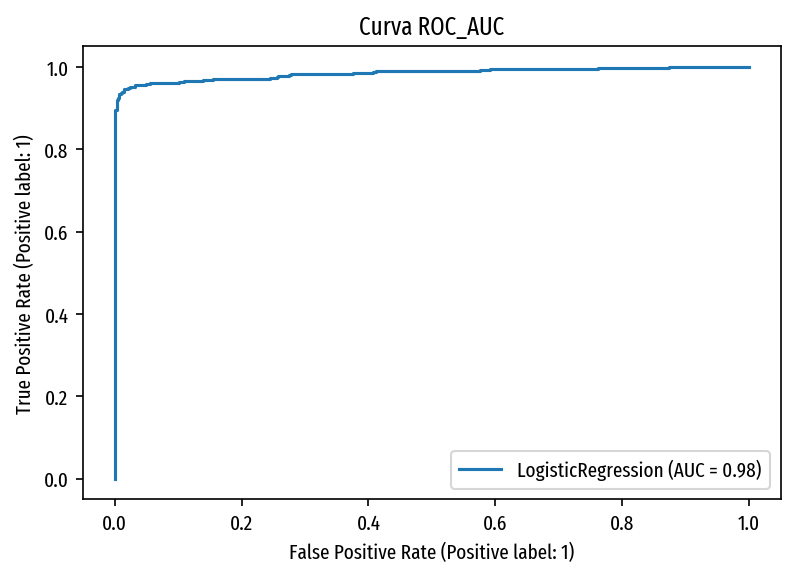

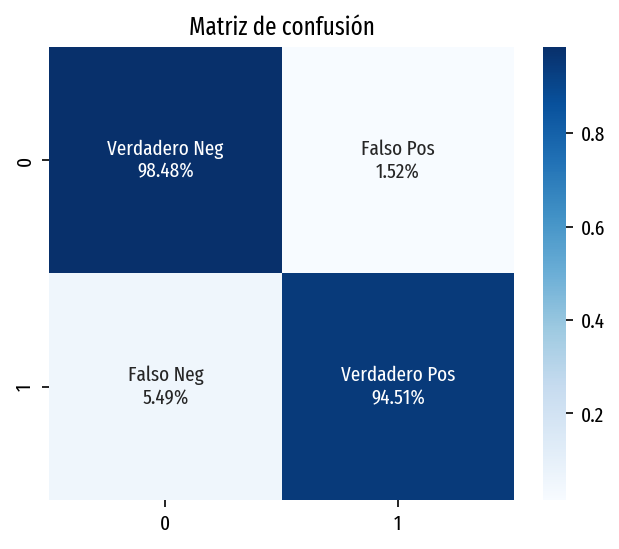

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       984
           1       0.97      0.95      0.96       492

    accuracy                           0.97      1476
   macro avg       0.97      0.96      0.97      1476
weighted avg       0.97      0.97      0.97      1476



In [67]:
model(model_LR,  X_train, y_train,  X_test, y_test)
model_evaluation(model_LR, X_test, y_test)

## Random Forest

Los árboles de decisión aleatorios (o Random Forest) son un algoritmo de machine learning del tipo supervisado que funciona mediante la creación de un conjunto de varios árboles de decisión, en donde se  utiliza la media de los resultados de cada árbol  para hacer una predicción. Cada uno de los árboles de decisión es construido a partir de una muestra aleatoria de datos y una selección aleatoria de las características en cada división del árbol (De ahí el nombre de random). Al combinar la salida de varios árboles, Random Forest es capaz de mitigar la sobreajuste que puede ocurrir con árboles de decisión individuales y mejorar la precisión en la predicción.
Una ventaja de los árboles de decisión es que son insensibles a la escala de los datos y a la presencia de outliers.

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
model_rf = RandomForestClassifier(criterion='gini', random_state=2, max_depth=4)

Cross Validation Score :  99.16%
ROC_AUC Score :  96.39%


<Figure size 750x600 with 0 Axes>

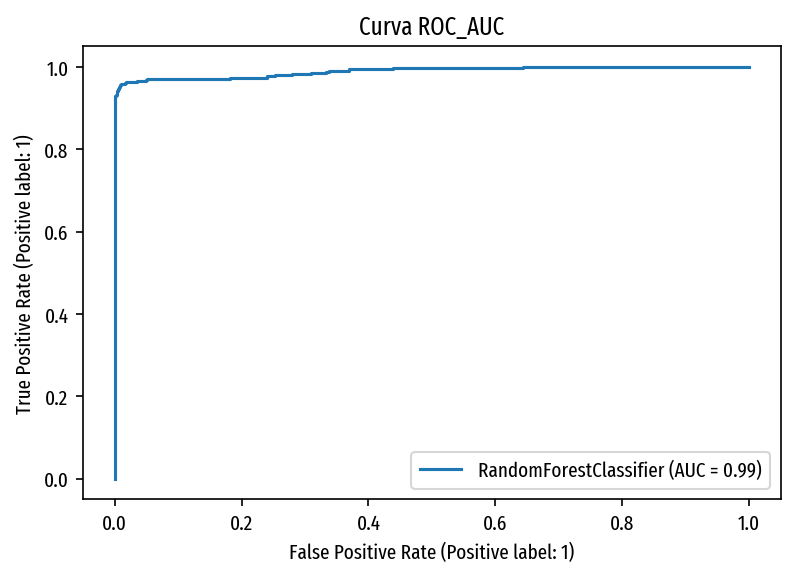

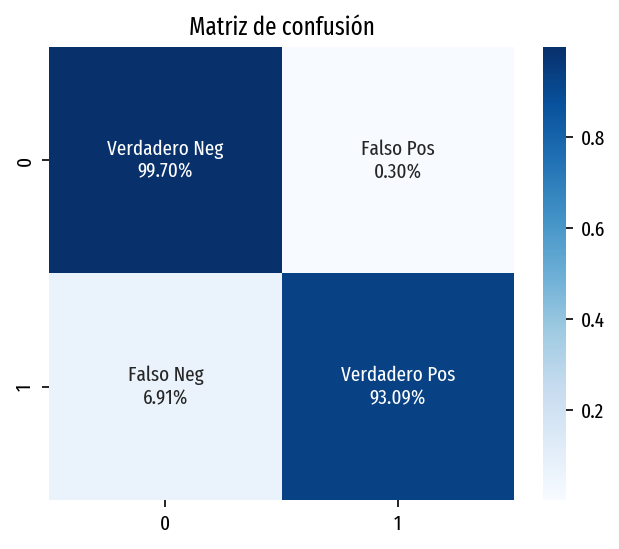

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       984
           1       0.99      0.93      0.96       492

    accuracy                           0.97      1476
   macro avg       0.98      0.96      0.97      1476
weighted avg       0.98      0.97      0.97      1476



In [76]:
model(model_rf,  X_train, y_train,  X_test, y_test)
model_evaluation(model_rf, X_test, y_test)

## SVC

El Support Vector Classifier (SVC) es un algoritmo de aprendizaje supervisado que se utiliza para la clasificación de datos. Funciona buscando un hiperplano en el espacio de características que mejor separe los datos en las diferentes clases. Este hiperplano es conocido como el vector de soporte, y se encuentra de manera tal que maximiza la margen entre las clases, es decir, la distancia mínima entre los datos más cercanos de las diferentes clases y el hiperplano.

Matemáticamente, se puede representar como un problema de optimización con restricciones, donde se busca encontrar los pesos $\boldsymbol{w}$ y el término independiente $b$ del hiperplano que separa las clases, sujeto a la restricción de que cada dato de entrenamiento debe estar en el lado correcto del hiperplano y tener una distancia mínima (margen) $\geqslant \lambda\_i$:

$$\min_{\boldsymbol{w}, b, \text{slack}i} \frac{1}{2} \boldsymbol{w}^T \boldsymbol{w} + C \sum{i=1}^n \lambda\_i$$

$$y_i(\boldsymbol{w}^T \boldsymbol{x}_i + b) \geqslant 1 - \lambda\_i, \quad \text{lambda}_i \geqslant 0, \quad i = 1, \dots, n$$

Donde $\boldsymbol{x}_i$ es un dato de entrenamiento, $y_i$ es su etiqueta y $C$ es un parámetro de regularización que controla la importancia de la margen versus la cantidad de datos que no cumplen la restricción (es decir, los datos en el margen).

La gracia es que aunque un conjunto de datos no sea linealmente separable en el hiperplano original, no implica que no lo sea en un espacio de mayores dimensiones. Aquí es donde entra el concepto de Kernel (lineal, polinómico, gaussiano, etc)

In [68]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [69]:
model_svc = Pipeline([('scaler', StandardScaler()),
                  ('svc', SVC(kernel='linear'))])

Cross Validation Score :  99.47%
ROC_AUC Score :  96.80%


<Figure size 750x600 with 0 Axes>

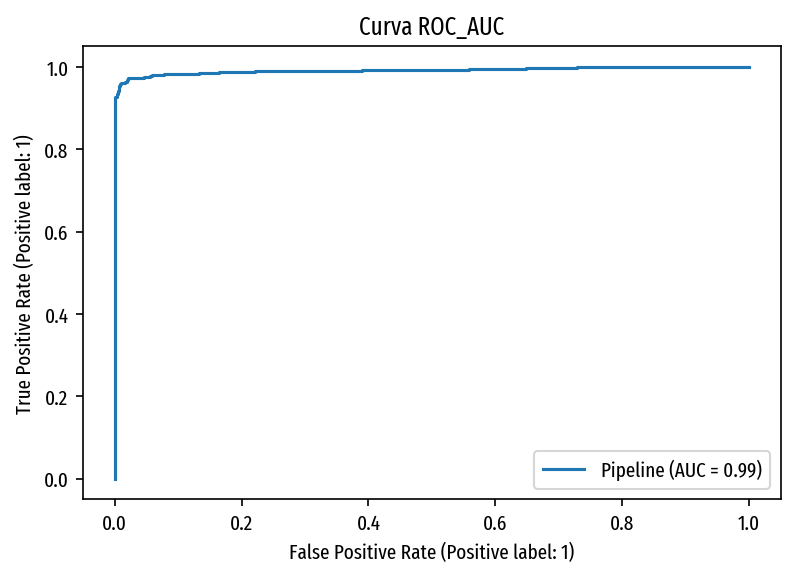

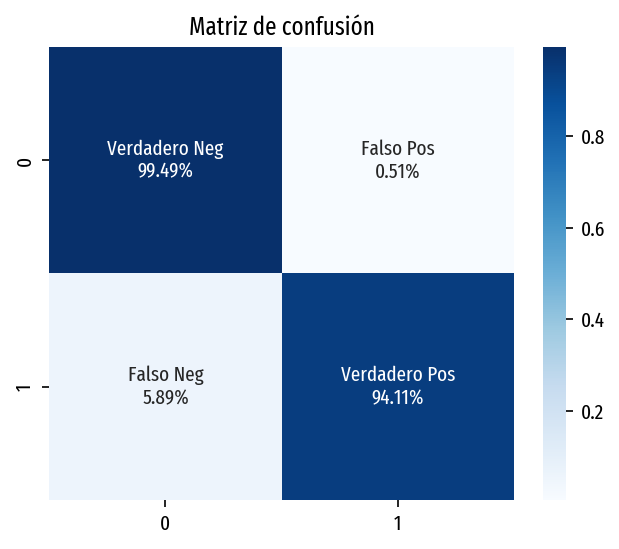

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       984
           1       0.99      0.94      0.96       492

    accuracy                           0.98      1476
   macro avg       0.98      0.97      0.97      1476
weighted avg       0.98      0.98      0.98      1476



In [70]:
model(model_svc,  X_train, y_train,  X_test, y_test)
model_evaluation(model_svc, X_test, y_test)

## XGBoost

XGBoost (eXtreme Gradient Boosting) es una técnica de aprendizaje automático supervisado utilizada para problemas de  clasificación y de regresión. 
Es una mejora del Gradient Boosting que utiliza una técnica de optimización llamada gradiente descendente estocástico para ajustar los parámetros del modelo. está formado por un conjunto de árboles de decisión individuales, entrenados de forma secuencial, de forma que cada nuevo árbol trata de mejorar los errores de los árboles anteriores. La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo, por lo que pertence a la familia de modelos de ensamble. 




In [71]:
import xgboost as xgb

In [72]:
model_xgb = Pipeline([('scaler', StandardScaler()),
                  ('xgb', xgb.XGBClassifier(objective='binary:logistic', nthread=-1) )])

Cross Validation Score :  99.80%
ROC_AUC Score :  98.53%


<Figure size 750x600 with 0 Axes>

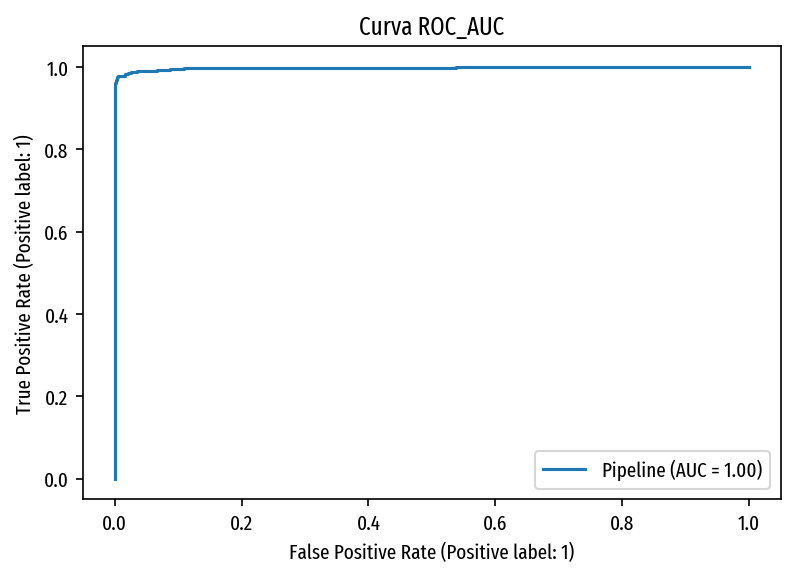

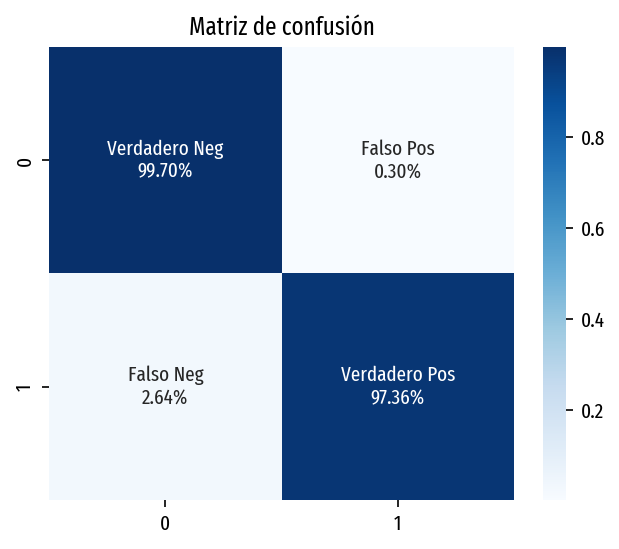

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       984
           1       0.99      0.97      0.98       492

    accuracy                           0.99      1476
   macro avg       0.99      0.99      0.99      1476
weighted avg       0.99      0.99      0.99      1476



In [73]:
model(model_xgb,  X_train, y_train,  X_test, y_test)
model_evaluation(model_xgb, X_test, y_test)

# Conclusión

De los 4 modelos utilizados, el que mejor desempeño obtuvo fue XGBoost, alcanzando un F1 Score de 0.99 y un ROC AUC de 98,53%. 
Logra identificar de manera correcta los verdaderos positivos (Fraude) un 97,36% de las veces. 

| **Modelo**  | **F1 Score** | **ROC AUC Score** | 
|-|-|-|
| Regresión lógistica | 0.97 |  96.49%| 
| Random Forest | 0.97 | 96.39%| 
| SVC | 0.98 | 96.80% | 
| XGBoost | 0.99| 98.53%|